## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import numpy as np
import re

import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
np.random.seed(SEED)

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2024-12-10 05:03:28--  https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-12-10 05:03:28 ERROR 404: Not Found.



FileNotFoundError: [Errno 2] No such file or directory: 'sonnets.txt'

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')
np.random.seed(42)

AssertionError: Are you sure you have concatenated all the strings?

### Data loading: "Евгений Онегин"


In [ ]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]
print(text[:500])

--2024-12-12 11:53:10--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.15’

onegin.txt.15       100%[===================>] 256.37K  --.-KB/s    in 0.02s   

2024-12-12 11:53:10 (10.9 MB/s) - ‘onegin.txt.15’ saved [262521/262521]

['\n', 'I\n', '\n', '«Мой дядя самых честных правил,\n', 'Когда не в шутку занемог,\n', 'Он уважать себя заставил\n', 'И лучше выдумать не мог.\n', 'Его пример другим наука;\n', 'Но, боже мой, какая скука\n', 'С больным сидеть и день и ночь,\n', 'Не отходя ни шагу прочь!\n', 'Какое низкое коварство\n', 'Полуживого забавлять,\n', 'Ему подушки поправлять,\n', 'Печально подносить лекарство,\n', 'Вздыхать и думат

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

text_combined = ' '.join(text).lower()  # Объединяем все строки в одну и убираем заглавные
text = ''.join(char for char in text_combined if re.match(r"[а-яё.,!?;:\-()\"'«»\s]", char)) # оставляем символы (^а-яА-ЯёЁ.,!?;:\-()\"'«»\s)
lines = [line.strip() for line in text.split('\n') if line.strip()] # Удаляем лишние пробелы в начале и конце строк, а также пустые строки
text = '\n'.join(lines)
text = re.sub(r'\n\s*\n+', '\n', text)
print(text[:-500])

«мой дядя самых честных правил,
когда не в шутку занемог,
он уважать себя заставил
и лучше выдумать не мог.
его пример другим наука;
но, боже мой, какая скука
с больным сидеть и день и ночь,
не отходя ни шагу прочь!
какое низкое коварство
полуживого забавлять,
ему подушки поправлять,
печально подносить лекарство,
вздыхать и думать про себя:
когда же черт возьмет тебя!»
так думал молодой повеса,
летя в пыли на почтовых,
всевышней волею зевеса
наследник всех своих родных.
друзья людмилы и руслана!
с героем моего романа
без предисловий, сей же час
позвольте познакомить вас:
онегин, добрый мой приятель,
родился на брегах невы,
где, может быть, родились вы
или блистали, мой читатель;
там некогда гулял и я:
но вреден север для меня
служив отлично-благородно,
долгами жил его отец,
давал три бала ежегодно
и промотался наконец.
судьба евгения хранила:
сперва  за ним ходила,
потом  ее сменил;
ребенок был резов, но мил.
, француз убогой,
чтоб не измучилось дитя,
учил его всему шутя,
не докучал мо

Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
tokens = sorted(set(text)) + ['<sos>']
print(len(tokens))
size = len(tokens)
print(tokens)

46
['\n', ' ', '!', '(', ')', ',', '-', '.', ':', ';', '?', '«', '»', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё']


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
# dict <index>:<char>
# Your great code here
idx_to_char = {idx: char for idx, char in enumerate(tokens)}
print(list(idx_to_char.items())[:10])
# dict <char>:<index>
# Your great code here
char_to_idx = {char: idx for idx, char in enumerate(tokens)}
print(list(char_to_idx.items())[:10])

[(0, '\n'), (1, ' '), (2, '!'), (3, '('), (4, ')'), (5, ','), (6, '-'), (7, '.'), (8, ':'), (9, ';')]
[('\n', 0), (' ', 1), ('!', 2), ('(', 3), (')', 4), (',', 5), ('-', 6), ('.', 7), (':', 8), (';', 9)]


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
# Параметры для генерации данных
BATCH_SIZE = 32
SEQ_LEN = 100
HIDDEN_SIZE = 128
NUM_LAYERS = 2
VOCAB_SIZE = len(tokens)
LEARNING_RATE = 0.001

# Кодирование текста в индексы на основе словаря
text_encoded = [char_to_idx[char] for char in text]
start_column = np.zeros((BATCH_SIZE, 1), dtype=np.int64)

# Генератор батчей для обучения
def generate_chunk():
    global text_encoded, start_column

    start_index = np.random.randint(0, len(text_encoded) - BATCH_SIZE * SEQ_LEN - 1)
    data = np.array(text_encoded[start_index:start_index + BATCH_SIZE * SEQ_LEN]).reshape((BATCH_SIZE, -1))
    yield np.hstack((start_column, data))

# Определение класса VanillaRNN
class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers):
        super(VanillaRNN, self).__init__()

        self.hidden_size = hidden_size

        # Слой эмбеддинга
        self.embedding = nn.Embedding(vocab_size, hidden_size)

        # RNN слой
        self.rnn = nn.RNN(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        # Полносвязный слой
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded, hidden)
        logits = self.fc(output)
        return logits, hidden

In [ ]:
# Создание модели и определение потерь и оптимизатора
model = VanillaRNN(VOCAB_SIZE, HIDDEN_SIZE, NUM_LAYERS).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Пример обучения
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in generate_chunk():
        batch = torch.tensor(batch, dtype=torch.long).to(device)

        inputs = batch[:, :-1]  # Входные последовательности
        targets = batch[:, 1:]  # Целевые последовательности

        optimizer.zero_grad()
        logits, _ = model(inputs)

        # Перестройка для соответствия формату целевых значений
        logits = logits.reshape(-1, VOCAB_SIZE)
        targets = targets.reshape(-1)

        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {total_loss:.4f}")

Plot the loss function (axis X: number of epochs, axis Y: loss function).

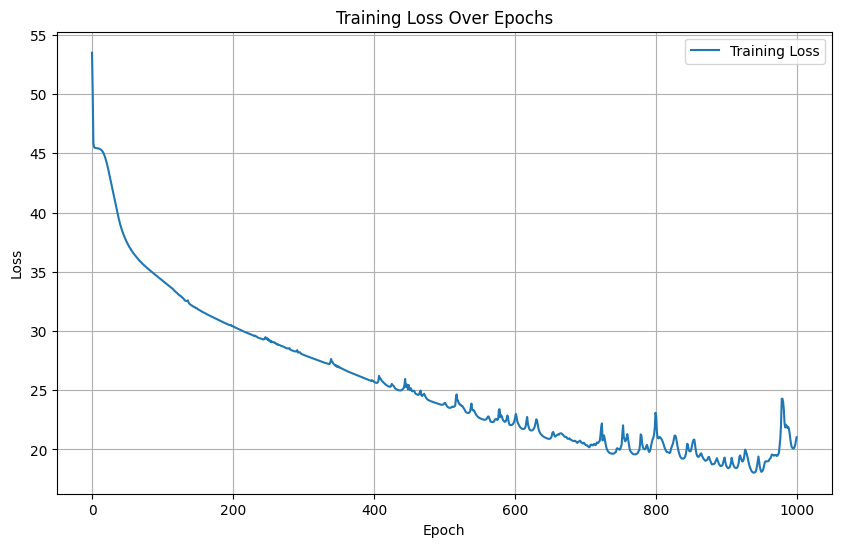

In [ ]:
# Your plot code here
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Генерация текста
model.eval()
def generate_text(model, start_seq, length):
    model.eval()
    generated = [char_to_idx[char] for char in start_seq]
    hidden = None

    for _ in range(length):
        input_seq = torch.tensor([generated[-SEQ_LEN:]], dtype=torch.long).to(device)
        logits, hidden = model(input_seq, hidden)
        next_char_idx = torch.argmax(logits[:, -1, :], dim=1).item()
        generated.append(next_char_idx)

    return ''.join(idx_to_char[idx] for idx in generated)

start_sequence = "евгений"
generated_text = generate_text(model, start_sequence, 200)
print(generated_text)

In [ ]:
# An example of generated text.
print('\ntemperature=0.1')
generated_text_01 = generate_sample(model, seed_phrase='я помню чудное мгновенье,', max_length=300, temperature=0.1)
print(generated_text_01)
print('\ntemperature=0.2')
generated_text_02 = generate_sample(model, seed_phrase='я помню чудное мгновенье', max_length=300, temperature=0.2)
print(generated_text_02)
print('\ntemperature=0.5')
generated_text_05 = generate_sample(model, seed_phrase='я помню чудное мгновенье', max_length=300, temperature=0.5)
print(generated_text_05)
print('\ntemperature=0.8')
generated_text_08 = generate_sample(model, seed_phrase='я помню чудное мгновенье', max_length=300, temperature=0.8)
print(generated_text_08)



temperature=0.1
я помню чудное мгновенье,
сердутся тамы оголосья,
и дотор седивогон.
еде звенитоменный долажной
замялуж стовались породена
илазалостовой,
и восновится чисой?),
обы, задоваль оновина увак,
об здающий пред на серанной,
в посветренный твенилость,
и всеринае сердаю
в этобы?».
тще подаморонный камный,
за

temperature=0.2
я помню чудное мгновенье,
сердутстваня содвел столит,
содово страсти варыет онт;
тотерной друзалисьен.
на сердце ного, в тоходы,
и все туминный головотно,
недотвилисой непетвель
настих не полосени».
«на доэт--ребой ужиль вед как нене вет,
светла страстить он стралита,
в следалсявит сорадо,
надене со

temperature=0.5
я помню чудное мгновенье,
от оталой онаги берные моей
ебел уветь словы ль, дленинный,
чтобик зеросталиченно
кажданный послечениских мо
м, порушкий тобен я мол,
какугда предвечен благорой.
бого, была задмуже сна увет,
поремной доловой,
и волнела свеегоет окок
ажилен и наченовый,
городалос извеля не д

temperature=0.8
я помню чудное мгновеньем
под

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
# Your beautiful code here
class LSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size

        # Встроенный LSTM слой
        # input_size = vocab_size, так как мы подаём one-hot векторы
        self.lstm = nn.LSTM(input_size=vocab_size, hidden_size=hidden_size, batch_first=True)

        # Полносвязный слой для преобразования скрытого состояния в предсказания
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        # x: [batch_size, seq_length, vocab_size]
        # hidden — кортеж (h0, c0)
        if hidden is None:
            batch_size = x.size(0)
            h0 = torch.zeros(1, batch_size, self.hidden_size, device=x.device)
            c0 = torch.zeros(1, batch_size, self.hidden_size, device=x.device)
            hidden = (h0, c0)

        # Пропускаем вход через LSTM
        out, hidden = self.lstm(x, hidden)
        # out: [batch_size, seq_length, hidden_size]

        # Применяем полносвязный слой для получения логитов
        out = self.fc(out)  # [batch_size, seq_length, vocab_size]

        return out, hidden


In [ ]:
hidden_size = 128
model1 = LSTM(size, hidden_size).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.0005)

# Создаем обучающие данные
SEQ_LENGTH = 40
STEP = 5

# Создание последовательностей и следующих символов
sequences = [text[i: i + SEQ_LENGTH] for i in range(0, len(text) - SEQ_LENGTH, STEP)]
next_chars = [text[i + SEQ_LENGTH] for i in range(0, len(text) - SEQ_LENGTH, STEP)]

# Функция для преобразования текста в one-hot
def text_to_one_hot(sequences, next_chars, vocab_size):
    num_samples = len(sequences)
    X = np.zeros((num_samples, SEQ_LENGTH, vocab_size), dtype=np.float32)
    y = np.zeros(num_samples, dtype=np.int64)  # Индексы следующих символов

    for i, seq in enumerate(sequences):
        for t, char in enumerate(seq):
            X[i, t, char_to_idx[char]] = 1  # One-hot кодирование символа
        y[i] = char_to_idx[next_chars[i]]  # Индекс следующего символа

    return X, y

# Преобразование последовательностей в one-hot представление
X, y = text_to_one_hot(sequences, next_chars, size)

# Преобразуем в тензоры PyTorch
X = torch.tensor(X, dtype=torch.float32, device=device)  # [num_samples, SEQ_LENGTH, vocab_size]
y = torch.tensor(y, dtype=torch.long, device=device)

In [ ]:
# Обучение модели
EPOCHS = 1000
BATCH_SIZE = 2048

history = []

for epoch in range(EPOCHS):
    model1.train()
    total_loss = 0

    for batch_idx in range(0, len(X), BATCH_SIZE):
        input_batch = X[batch_idx: batch_idx + BATCH_SIZE]
        target_batch = y[batch_idx: batch_idx + BATCH_SIZE]

        current_batch_size = input_batch.size(0)

        # Инициализация скрытого состояния
        h0 = torch.zeros(1, current_batch_size, hidden_size, device=device)
        c0 = torch.zeros(1, current_batch_size, hidden_size, device=device)
        hidden = (h0, c0)

        optimizer.zero_grad()

        # Forward проход
        outputs, hidden = model1(input_batch, hidden)  # outputs: [batch_size, sequence_length, vocab_size]

        # Используем только последний временной шаг
        outputs_last = outputs[:, -1, :]  # [batch_size, vocab_size]

        # Вычисляем loss
        loss = loss_func(outputs_last, target_batch)  # target_batch: [batch_size]
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    history.append(total_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch + 1}/{EPOCHS}], Loss: {total_loss:.4f}")

torch.save(model.state_dict(), 'LSTM_state.pth')

Epoch [5/1000], Loss: 45.4385
Epoch [10/1000], Loss: 45.0568
Epoch [15/1000], Loss: 43.9567
Epoch [20/1000], Loss: 41.9927
Epoch [25/1000], Loss: 40.3298
Epoch [30/1000], Loss: 38.9347
Epoch [35/1000], Loss: 37.6430
Epoch [40/1000], Loss: 36.7409
Epoch [45/1000], Loss: 36.0585
Epoch [50/1000], Loss: 35.6489
Epoch [55/1000], Loss: 35.1759
Epoch [60/1000], Loss: 34.8232
Epoch [65/1000], Loss: 34.5439
Epoch [70/1000], Loss: 34.2864
Epoch [75/1000], Loss: 34.0154
Epoch [80/1000], Loss: 33.7699
Epoch [85/1000], Loss: 33.5694
Epoch [90/1000], Loss: 33.4165
Epoch [95/1000], Loss: 33.1994
Epoch [100/1000], Loss: 33.0405
Epoch [105/1000], Loss: 32.8436
Epoch [110/1000], Loss: 32.6644
Epoch [115/1000], Loss: 32.5121
Epoch [120/1000], Loss: 32.3723
Epoch [125/1000], Loss: 32.5578
Epoch [130/1000], Loss: 32.1375
Epoch [135/1000], Loss: 31.9645
Epoch [140/1000], Loss: 31.8076
Epoch [145/1000], Loss: 31.6711
Epoch [150/1000], Loss: 31.5844
Epoch [155/1000], Loss: 31.5855
Epoch [160/1000], Loss: 31.3

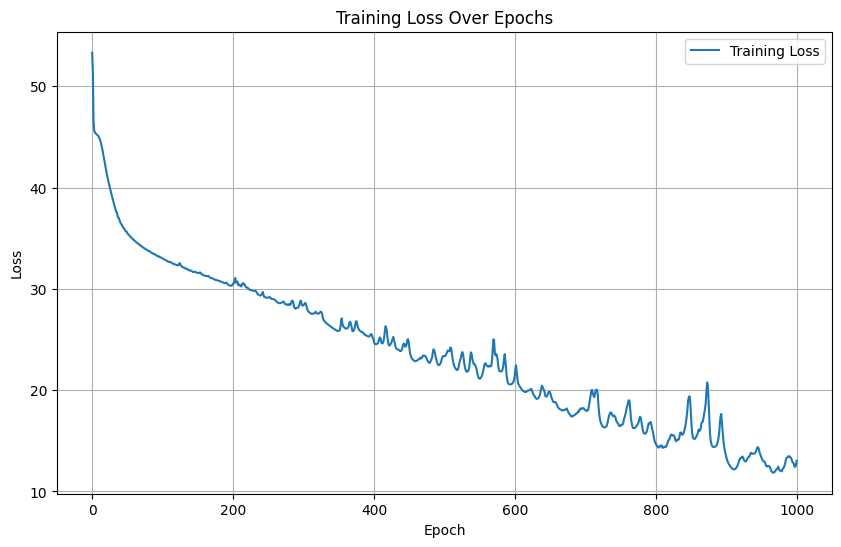

In [ ]:
# Your plot code here
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Видно, что потери уменьшились по сравнению с ванильной RNN

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
def generate_text_lstm(model, seed_phrase, max_length=200, temperature=1.0):
    """
    Генерация текста с использованием модели LSTM.
    :param model: обученная модель LSTM
    :param seed_phrase: начальная строка для генерации текста
    :param max_length: количество символов для генерации
    :param temperature: параметр температуры для управления случайностью
    :return: сгенерированный текст
    """
    model.eval()  # Переключаем модель в режим оценки

    # Преобразуем начальный текст в индексы
    input_indices = [char_to_idx[ch] for ch in seed_phrase]
    input_tensor = torch.tensor([input_indices], dtype=torch.long, device=device)  # [1, len_seed]

    # Инициализируем скрытое состояние
    h0 = torch.zeros(1, 1, model.hidden_size, device=device)  # [num_layers, batch_size, hidden_size]
    c0 = torch.zeros(1, 1, model.hidden_size, device=device)  # [num_layers, batch_size, hidden_size]
    hidden = (h0, c0)

    # Пропускаем seed_phrase через модель
    for i in range(input_tensor.size(1) - 1):
        x = F.one_hot(input_tensor[:, i], num_classes=size).float()  # [1, vocab_size]
        x = x.unsqueeze(0)  # Преобразуем в [1, 1, vocab_size]
        _, hidden = model(x, hidden)

    # Начинаем генерацию текста
    generated_text = seed_phrase
    current_char_idx = input_tensor[:, -1]  # Последний символ seed_phrase

    for _ in range(max_length):
        # Преобразуем текущий символ в one-hot
        x = F.one_hot(current_char_idx, num_classes=size).float()  # [1, vocab_size]
        x = x.unsqueeze(0)  # Преобразуем в [1, 1, vocab_size]

        # Пропускаем через модель
        logits, hidden = model(x, hidden)

        # Применяем температуру
        logits = logits.squeeze(1)  # Убираем временную размерность: [1, vocab_size]
        probabilities = F.softmax(logits / temperature, dim=-1).squeeze().detach().cpu().numpy()

        # Выбираем следующий символ
        next_char_idx = np.random.choice(len(probabilities), p=probabilities)
        next_char = idx_to_char[next_char_idx]

        # Добавляем символ в сгенерированный текст
        generated_text += next_char
        current_char_idx = torch.tensor([next_char_idx], device=device, dtype=torch.long)  # Убираем лишнюю размерность

    return generated_text


In [ ]:
print('\ntemperature=0.1')
generated_text_01 = generate_text_lstm(model1, seed_phrase='я помню чудное мгновенье,', max_length=300, temperature=0.1)
print(generated_text_01)
print('\ntemperature=0.2')
generated_text_02 = generate_text_lstm(model1, seed_phrase='я помню чудное мгновенье', max_length=300, temperature=0.2)
print(generated_text_02)
print('\ntemperature=0.5')
generated_text_05 = generate_text_lstm(model1, seed_phrase='я помню чудное мгновенье', max_length=300, temperature=0.5)
print(generated_text_05)
print('\ntemperature=1')
generated_text_1 = generate_text_lstm(model1, seed_phrase='я помню чудное мгновенье', max_length=300, temperature=1)
print(generated_text_1)
print('\ntemperature=2')
generated_text_2 = generate_text_lstm(model1, seed_phrase='я помню чудное мгновенье', max_length=300, temperature=2)
print(generated_text_2)
print('\ntemperature=0.35')
generated_text_2 = generate_text_lstm(model1, seed_phrase='я помню чудное мгновенье', max_length=300, temperature=0.35)
print(generated_text_2)


temperature=0.1
я помню чудное мгновенье,
садь бо млуг овосью везданья,
я в сваю без разаразалитья,
я два ь руззуму долания
зай в ласьмаланя
встрав бых дулыхоловой
всася взаланяя,
на волой,
но призвиловый,
но гойцик скранном
ончина в закакий,
вздем, мордровылья
своть у  з го улитый странь,
закля, следный скриник.
вся вздазгля устричилый
ме

temperature=0.2
я помню чудное мгновенье,
сашь бо могруг о весеет.
в труждой взгругой
бег бы дашилыхлат,
хлать брадрознымый слений
света у залямилать,
встам зазазаленный слес
кам мурца разаряланя,
и с в за узузульянавала,
я для, звей ссееть,
с рездамяменней
встраца зазням
вотомным модей,
модей браздудетенитрадь
иселя,
с рась заладоегинити

temperature=0.5
я помню чудное мгновенье,
садь бу грудня супризлычты,
с демна серний,
и несьененей»
и ледольна,
и вы лья,
как ликлислицить.
быль чужны, длезной?
не ле лю!
встоваш с васкаканте,
безвлацушить,
я звы ь бразузузкихортрам
одотой,
с домо, моредцеразденем,
что накоснка,
зашина;
взраде жерней радне
с прим

В результате при низких темературах получаем высокую предскзауемость,повторяющиеся фразы, похожие слова. С повышением температуры повышается разнообразность. Но при слишком большой символы почти хаотичные. Лично по мне для наших результатов, лучше всего температура 0.4.


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here
# Сохранение модели
torch.save(model1, 'model1.pth')
print('Модель сохранена в файл: model1.pth')

# Загрузка модели
model_load = torch.load('model1.pth', weights_only=False)
model_load.eval()  # Переводим модель в режим оценки
print('Модель загружена и переведена в режим оценки')
print()
# Генерация текста загруженной моделью
print(generate_text_lstm(model_load, seed_phrase='я помню чудное мгновенье...', max_length=300, temperature=0.8))

Модель сохранена в файл: model1.pth
Модель загружена и переведена в режим оценки

я помню чудное мгновенье...
 «оборонит, и  осящитупельный,
 я тетси прулссаститстрелель о дем и дела
 и тчулуской,
 теть быль прастротанный лский как бы легосулава.
 и на убод бенумиханя,
 тотвой взняю влащушь наговоги;
 тег поденный муствонаюлься.
 на дно жеж; на ночетоть вашиссисоегоная
 а такомней,
 те не десодавенье глади


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)